# Adding Genre fields
### Movie List Project - Notebook #3
### Max Ruther

## Motivation and Overview

In the previous notebook, I trained a decision tree classifier to predict my enjoyment of a movie, based on various critics' ratings. At the end of that analysis, it was determined that adding attributes to the training data, specifically ones relating to genre, might improve that model's performance.

To this end, I have programmatically parsed the genre attribute of the Online Movie Database (OMDb) records (which were also sourced to create the *critic_ratings* table featured in the preceding two notebooks.) I will here import my movie genre table from my MySQL database, join it to the training data I used in the previous notebook, and train a new classifier on this enriched set.

## Setup

##### Imports

In [7]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine

import os

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

##### Seed for Randomization

In [8]:
rand_st = 44

##### Connect the SQLAlchemy engine to my local MySQL movie database

In [9]:
# Read in my database's creds/URL from a file.
movie_db_url = None
with open('../.secret/movie_db_url.txt', 'r') as f:
    movie_db_url = f.read().strip()

# Connect to my MySQL movie database.
engine = create_engine(movie_db_url)
conn = engine.connect()

## Loading in Genre Table

In [10]:
query = """SELECT * FROM genres;"""

genre_df = pd.read_sql_query(query, engine, index_col='Movie_ID')
genre_df['Year'] = genre_df['Year'].astype('int64')
genre_df.head(5)

,Title,Year,Drama,Comedy,History,Animation,Adventure,Romance,Action,SciFi,...,Horror,Thriller,Family,Documentary,War,Sport,Music,Biography,Short,Western
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,Nickel Boys,2024,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Brutalist,2024,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hard Truths,2024,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Vermiglio,2024,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Wallace & Gromit: Vengeance Most Fowl,2024,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
genre_df.iloc[:, 2:]

,Drama,Comedy,History,Animation,Adventure,Romance,Action,SciFi,Crime,Mystery,...,Horror,Thriller,Family,Documentary,War,Sport,Music,Biography,Short,Western
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
286,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
287,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Descriptive statistics of the Genre fields

In [12]:
genre_df.iloc[:, 2:].describe().sort_values(by='mean', axis=1, ascending=False)

,Drama,Comedy,Action,Adventure,Romance,Crime,Thriller,Fantasy,Horror,SciFi,...,Family,Animation,History,Music,Biography,Documentary,War,Western,Sport,Short
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,...,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,0.584775,0.377163,0.204152,0.186851,0.148789,0.124567,0.121107,0.114187,0.103806,0.100346,...,0.058824,0.055363,0.034602,0.034602,0.024221,0.017301,0.017301,0.010381,0.003460,0.003460
std,0.493616,0.485517,0.403780,0.390468,0.356498,0.330801,0.326818,0.318590,0.305538,0.300982,...,0.235702,0.229085,0.183087,0.183087,0.154003,0.130617,0.130617,0.101531,0.058824,0.058824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Genre Prevalence
Honing in on the mean of these genre attributes, which represents the proportion of the movies they're associated with:

In [13]:
genre_prevalence = genre_df.iloc[:, 2:].describe().sort_values(by='mean', axis=1, ascending=False).loc['mean']
genre_prevalence

Drama          0.584775
Comedy         0.377163
Action         0.204152
Adventure      0.186851
Romance        0.148789
Crime          0.124567
Thriller       0.121107
Fantasy        0.114187
Horror         0.103806
SciFi          0.100346
Mystery        0.086505
Family         0.058824
Animation      0.055363
History        0.034602
Music          0.034602
Biography      0.024221
Documentary    0.017301
War            0.017301
Western        0.010381
Sport          0.003460
Short          0.003460
Name: mean, dtype: float64

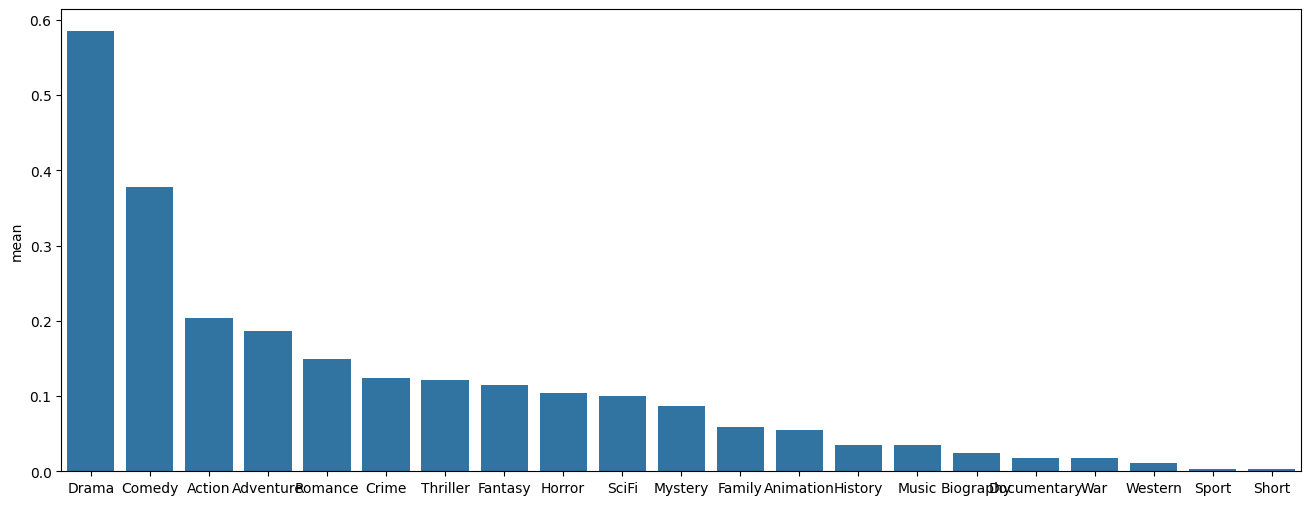

In [14]:
plt.figure(figsize=(16,6))
sns.barplot(genre_prevalence)
plt.show()

Drama and Comedy are by far the most common. Only 9 of these genres are associated with more than 10% of the movies.

## Importing the data from the preceding analysis

In [15]:
input_data_filename = 'mList_df_all.csv'
input_data_dirname = '../data/analysis/2-Predicting_My_Ratings'

In [16]:
watch_df = pd.read_csv(f"{input_data_dirname}/{input_data_filename}", index_col='Movie_ID')
print(watch_df.shape)
watch_df.head()

(200, 7)


,Title,Year,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome
Movie_ID,,,,,,,
6,If Beale Street Could Talk,2018,0.71,0.95,0.87,4.0,1
7,Mad Max: Fury Road,2015,0.81,0.97,0.90,4.0,1
8,Babygirl,2024,0.66,0.77,0.81,3.5,0
9,Inside the Yellow Cocoon Shell,2023,0.67,0.94,0.94,3.5,1
10,Nosferatu,2024,0.76,0.85,0.78,4.0,1


In [17]:
wg_df = watch_df.merge(genre_df, on=['Movie_ID', 'Title', 'Year'], how='inner')
wg_df.head()

,Title,Year,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,anyAwesome,Drama,Comedy,History,...,Horror,Thriller,Family,Documentary,War,Sport,Music,Biography,Short,Western
Movie_ID,,,,,,,,,,,,,,,,,,,,,
6,If Beale Street Could Talk,2018,0.71,0.95,0.87,4.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Mad Max: Fury Road,2015,0.81,0.97,0.90,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Babygirl,2024,0.66,0.77,0.81,3.5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Inside the Yellow Cocoon Shell,2023,0.67,0.94,0.94,3.5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Nosferatu,2024,0.76,0.85,0.78,4.0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Creating a list of the genre attributes, which come after the 'anyAwesome' attribute in the merged dataframe:

In [18]:
first_genre_attr_index = wg_df.columns.get_loc('anyAwesome') + 1
genre_attrs = list(wg_df.columns[first_genre_attr_index:])
genre_attrs

['Drama',
 'Comedy',
 'History',
 'Animation',
 'Adventure',
 'Romance',
 'Action',
 'SciFi',
 'Crime',
 'Mystery',
 'Fantasy',
 'Horror',
 'Thriller',
 'Family',
 'Documentary',
 'War',
 'Sport',
 'Music',
 'Biography',
 'Short',
 'Western']

Counting how many movies are associated with each genre:

In [19]:
wg_df.loc[:, genre_attrs].sum().sort_values(ascending=False)

Drama          113
Comedy          82
Action          39
Adventure       38
Romance         34
Crime           28
Thriller        27
Fantasy         25
SciFi           24
Horror          22
Mystery         20
Family          13
Animation        6
History          5
Music            5
Biography        5
War              4
Documentary      2
Western          2
Short            1
Sport            0
dtype: int64

### Counting Awesome-ish Movies by Genre

How many movies in a given genre are at least somewhat awesome, and how many aren't?

In this next cell I count this for the _Drama_ genre only. After that, I use a loop to accomplish this count for all genres and combine the results into one dataframe.

In [20]:
wg_df[['Drama','anyAwesome']].groupby('anyAwesome').sum('Drama')

,Drama
anyAwesome,
0,65
1,48


In [21]:
gen_awe_aggs = pd.DataFrame()
for colname in wg_df.iloc[:, first_genre_attr_index:]:
    r = wg_df[[colname,'anyAwesome']].groupby('anyAwesome', as_index=False).sum(colname)

    if gen_awe_aggs.empty:
        gen_awe_aggs = r
    else:
        gen_awe_aggs = gen_awe_aggs.merge(r, on='anyAwesome')

gen_awe_aggs.head()

,anyAwesome,Drama,Comedy,History,Animation,Adventure,Romance,Action,SciFi,Crime,...,Horror,Thriller,Family,Documentary,War,Sport,Music,Biography,Short,Western
0,0,65,64,2,4,31,24,30,16,19,...,17,18,13,1,3,0,1,4,1,2
1,1,48,18,3,2,7,10,9,8,9,...,5,9,0,1,1,0,4,1,0,0


I would like to visualize these counts with a bar chart. To that end, I will 'melt' the dataframe preceding, by forming an attribute _Genre_ indicating the genre being counted for.

In [22]:
test_df = gen_awe_aggs.melt(id_vars='anyAwesome',var_name='Genre', value_name='Count')
test_df.head(10)

,anyAwesome,Genre,Count
0,0,Drama,65
1,1,Drama,48
2,0,Comedy,64
3,1,Comedy,18
4,0,History,2
5,1,History,3
6,0,Animation,4
7,1,Animation,2
8,0,Adventure,31
9,1,Adventure,7


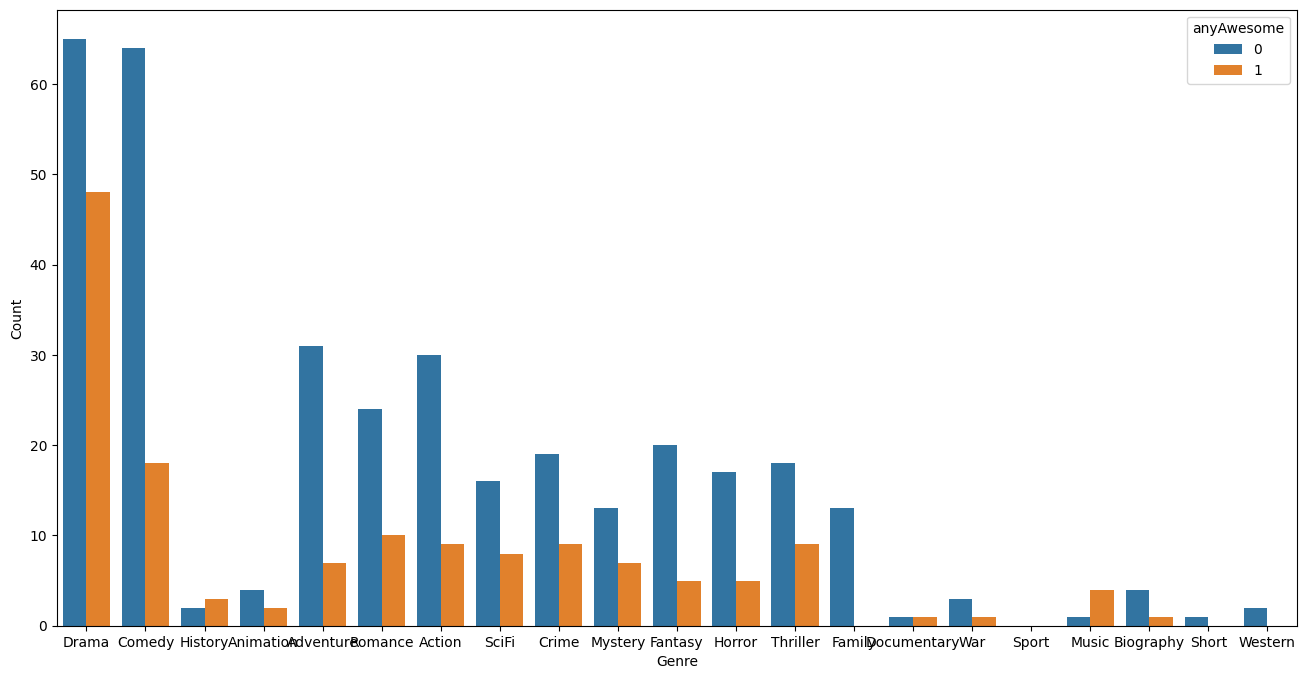

In [23]:
plt.figure(figsize=(16,8))
sns.barplot(data=test_df, x = 'Genre', y='Count', hue='anyAwesome')
plt.show()

The bar chart certainly illustrates the prevalences of the Drama and Comedy genres. However, this grouped barchart isn't clarifying which genres might be helpful in predicting whether I'll rate a given movie as awesome-ish. This concern might be better addressed by correlation analysis.

## Correlation Analysis

I begin by looking at the genres with the highest magnitude of correlation to the target. These are the absolute values of the predictors' correlations:

In [24]:
abs(wg_df.loc[:, genre_attrs + ['anyAwesome']].corr()['anyAwesome'][:-1]).sort_values(ascending=False)

Drama          0.229719
Comedy         0.195878
Family         0.185042
Music          0.160056
Adventure      0.150164
Fantasy        0.104496
Action         0.103866
History        0.091947
Horror         0.076806
Western        0.070535
Short          0.049750
Biography      0.044271
Documentary    0.036336
Romance        0.034536
War            0.024305
Mystery        0.014178
Crime          0.007355
Thriller       0.002801
SciFi          0.002618
Animation      0.001247
Sport               NaN
Name: anyAwesome, dtype: float64

At values less than roughly 0.25, all of these correlations are on the weaker side. Drama and Comedy are the two highest absolute correlations, in addition to their being the most frequently represented, as noted just previously.

The genres _Music_, _Family_, _Fantasy_, and _Horror_ follow next and are the only other correlations exceeding 0.1 . But the usefulness of a couple of these might be marginal, as _Music_ and _Family_  are associated with so few movies.

Next, listing the correlations as they are (instead of listing their absolute values, as I've done):

In [25]:
wg_df.loc[:, genre_attrs + ['anyAwesome']].corr()['anyAwesome'][:-1].sort_values(ascending=False)

Drama          0.229719
Music          0.160056
History        0.091947
Documentary    0.036336
Mystery        0.014178
Thriller       0.002801
SciFi          0.002618
Animation      0.001247
Crime         -0.007355
War           -0.024305
Romance       -0.034536
Biography     -0.044271
Short         -0.049750
Western       -0.070535
Horror        -0.076806
Action        -0.103866
Fantasy       -0.104496
Adventure     -0.150164
Family        -0.185042
Comedy        -0.195878
Sport               NaN
Name: anyAwesome, dtype: float64

Drama is the most positively correlated genre while Comedy is the most negatively correlated. 

As a big fan of comedy generally, I find this tough to face. In the previous analysis, one result suggested that I might be a contrarian in how I rate movies. Is this current analysis now suggesting that I'm humorless too??

## Splitting the data for modelling

### Create the predictor set

I am using all genre attributes. To create the training data, I am thus only excluding the movie's title, year, and the _anyAwesome_ field.

In [26]:
X0 = wg_df.drop(['anyAwesome', 'Title', 'Year'], axis=1)
X0.head()

,IMDB_Score,RT_Score,MetaC_Score,Ebert_Score,Drama,Comedy,History,Animation,Adventure,Romance,...,Horror,Thriller,Family,Documentary,War,Sport,Music,Biography,Short,Western
Movie_ID,,,,,,,,,,,,,,,,,,,,,
6,0.71,0.95,0.87,4.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0.81,0.97,0.90,4.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0.66,0.77,0.81,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.67,0.94,0.94,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0.76,0.85,0.78,4.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Create the target set

In [27]:
y0 = wg_df.loc[:, ('anyAwesome')]
y0.head()

Movie_ID
6     1
7     1
8     0
9     1
10    1
Name: anyAwesome, dtype: int64

### Split these into test and train sets.

In [28]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2,
                                                    random_state=rand_st)

### Save these split-up sets to files

In [29]:
output_dirname = '../data/analysis/3-Incorporating_Genre'

In [31]:
X0_train.to_csv(f'{output_dirname}/nb3_X_train.csv')
X0_test.to_csv(f'{output_dirname}/nb3_X_test.csv')
y0_train.to_csv(f'{output_dirname}/nb3_y_train.csv')
y0_test.to_csv(f'{output_dirname}/nb3_y_test.csv')

## Modelling - Redoing the Decision Tree

Creating and training a decision tree with the same hyperparameters of that created in the previous analysis:

In [32]:
DT_0 = DecisionTreeClassifier(criterion='entropy', max_depth=5,
                              random_state=rand_st)

DT_0.fit(X0_train, y0_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=44)

Using this model to make predictions on the test data, then evaluating that test performance:

In [33]:
test_preds = DT_0.predict(X0_test)
print(classification_report(test_preds, y0_test))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74        19
           1       0.81      0.62      0.70        21

    accuracy                           0.72        40
   macro avg       0.74      0.73      0.72        40
weighted avg       0.74      0.72      0.72        40



### Discussing the test performance

This test performance is superior to the previous one, as the accuracy, precision, and recall have all increased:
- **Accuracy** increased from 0.76 to **0.79**
- **Precision** increased from 0.58 to **0.65**
- **Recall** increased from 0.65 to **0.71**


#### Particularly enjoying the boosted recall

I feel somewhat gratified by the improvements across these three performance metrics. The boost in recall might be my favorite development. It alleviates a concern I voiced in the previous analysis, that the model's recall was less than I liked, at 0.65. It suggested that such a model could have steered me away from 35% of the awesome-ish movies that I'd seen, were I solely deferring to that model.

Lucky for me, this latest model sees a boost in recall that substantially assuages my FOMO. Its recall here is 0.71 , which suggests I'd now only miss 29% of the awesome-ish movies I've seen. 

In successes like these, I control my FOMO; FOMO doesn't control me.

## Visualizing the Decision Tree

To further analyze this latest decision tree model, I visualize it below:

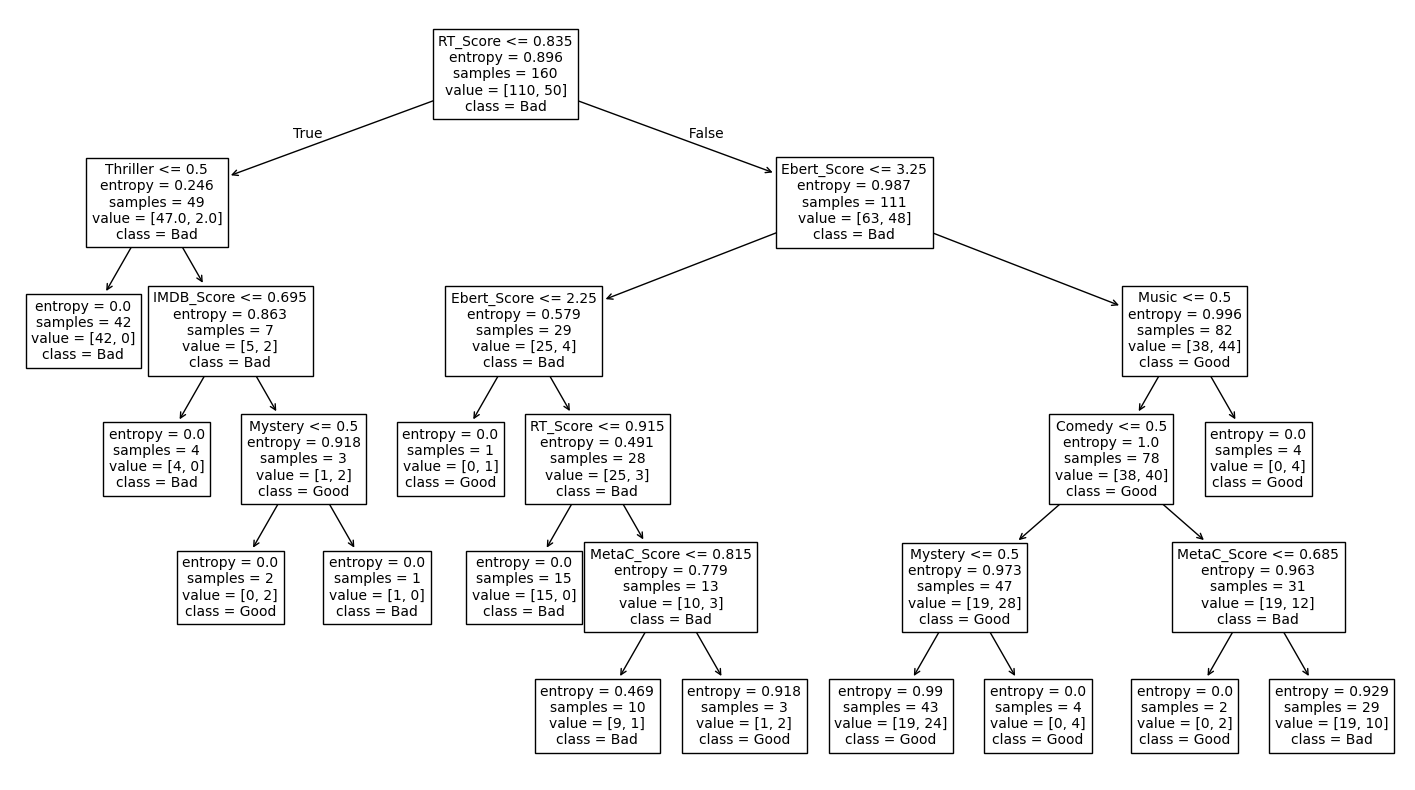

In [34]:
plt.figure(figsize=(18,10))
plot_tree(DT_0, feature_names=X0.columns, class_names=['Bad', 'Good'], fontsize=10)
plt.show()

Some insights I'm interpreting from this visualized tree are complicating the positive assessment that I voiced in the previous section.

1. The benefit of the two deepest nodes of the tree are again virtually useless. I judge that benefit to be low enough that pruning these lowest leaf nodes would be worthy, to trade that marginal predictive value for more simplicity overall.

2. The goal that motivated the incorporation of genre attributes, to better break up the branch that starts at node #6, was here unmet. That branch is nearly identical to the corresponding one in the previous tree. It might now use _Romance_ instead of _RT_Score_ early on as a distinguishing attribute, but this change is nothing compared to this branches highly similar groupings of similar counts.

Though I know disappointing outcomes like this second observation are natural occurences in investigation, I am finding it a little bitter. It was a long effort for me to incorporate the genre data- it involved a lot of development to expand the data ingestion programs, among other things.

But I'm not as defeated as I sound, because I feel confident that I will appreciate these genre attributes in future analyses.

## Future Work

My main interest for future analysis is to incorporate several attributes available in my movie database which are yet unused and do not relate to critics' ratings or genre. I would like to incorporate:
    - Date fields, like _Release Year_ and _Watch Date_.
    - My _Watched in Theater_ field, which indicates whether I viewed the movie in-theater or at home.
    - Some miscellaneous fields, like _Runtime_ and _Box Office Earnings_.

Once I include these fields for my analysis, I would want to do some extensive EDA with ample visualizations. As a sidenote, if these notebooks felt light on EDA, it's because they were originally written to quickly slap together decision trees, not as deep dives or presentations. But organically, they expanded into documents of the progress of this movie-list database project.

Lastly, in future work, I intend to experiment more with the encoding of my personal _Rating_ field. I would also want to try other machine learning methods. If I put aside my interest in model interpretability, it might be fun to explore a method that trades that quality for predictive accuracy.